# Q-Learning

In [1]:
import matplotlib.pyplot as plt
import os
import random
import sys

from algorithms.q_learning import QLearning

Evaluate 1000/200000: -0.34
Evaluate 2000/200000: -0.268
Evaluate 3000/200000: -0.048
Evaluate 4000/200000: 0.072
Evaluate 5000/200000: 0.004
Evaluate 6000/200000: 0.084
Evaluate 7000/200000: 0.116
Evaluate 8000/200000: 0.152
Evaluate 9000/200000: 0.308
Evaluate 10000/200000: 0.24
Evaluate 11000/200000: 0.344
Evaluate 12000/200000: 0.296
Evaluate 13000/200000: 0.324
Evaluate 14000/200000: 0.352
Evaluate 15000/200000: 0.368
Evaluate 16000/200000: 0.332
Evaluate 17000/200000: 0.4
Evaluate 18000/200000: 0.464
Evaluate 19000/200000: 0.44
Evaluate 20000/200000: 0.576
Evaluate 21000/200000: 0.508
Evaluate 22000/200000: 0.528
Evaluate 23000/200000: 0.588
Evaluate 24000/200000: 0.524
Evaluate 25000/200000: 0.536
Evaluate 26000/200000: 0.596
Evaluate 27000/200000: 0.496
Evaluate 28000/200000: 0.564
Evaluate 29000/200000: 0.608
Evaluate 30000/200000: 0.548
Evaluate 31000/200000: 0.664
Evaluate 32000/200000: 0.56
Evaluate 33000/200000: 0.584
Evaluate 34000/200000: 0.592
Evaluate 35000/200000: 0.6

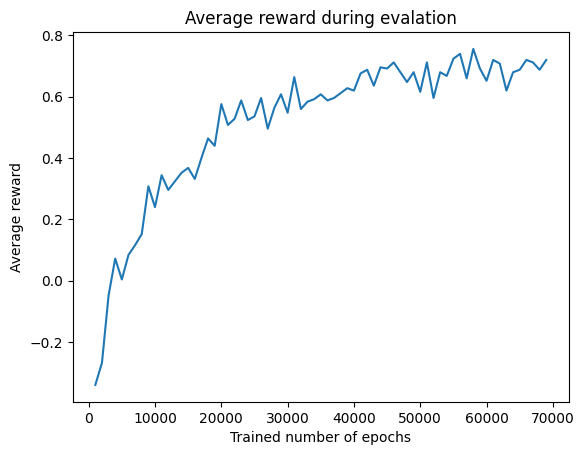

([1000,
  2000,
  3000,
  4000,
  5000,
  6000,
  7000,
  8000,
  9000,
  10000,
  11000,
  12000,
  13000,
  14000,
  15000,
  16000,
  17000,
  18000,
  19000,
  20000,
  21000,
  22000,
  23000,
  24000,
  25000,
  26000,
  27000,
  28000,
  29000,
  30000,
  31000,
  32000,
  33000,
  34000,
  35000,
  36000,
  37000,
  38000,
  39000,
  40000,
  41000,
  42000,
  43000,
  44000,
  45000,
  46000,
  47000,
  48000,
  49000,
  50000,
  51000,
  52000,
  53000,
  54000,
  55000,
  56000,
  57000,
  58000,
  59000,
  60000,
  61000,
  62000,
  63000,
  64000,
  65000,
  66000,
  67000,
  68000,
  69000],
 [-0.34,
  -0.268,
  -0.048,
  0.072,
  0.004,
  0.084,
  0.116,
  0.152,
  0.308,
  0.24,
  0.344,
  0.296,
  0.324,
  0.352,
  0.368,
  0.332,
  0.4,
  0.464,
  0.44,
  0.576,
  0.508,
  0.528,
  0.588,
  0.524,
  0.536,
  0.596,
  0.496,
  0.564,
  0.608,
  0.548,
  0.664,
  0.56,
  0.584,
  0.592,
  0.608,
  0.588,
  0.596,
  0.612,
  0.628,
  0.62,
  0.676,
  0.688,
  0.636,
  0.

In [3]:
q_learing = QLearning('TicTacToe')
q_learing.learn(verbose = True)

In [ ]:
q_learing = QLearning('TicTacToe', learning_rate = 0.5, discount_factor = 0.9, epsilon = 0.5)
q_learing.load('test.pkl')